<img width="800px" src="../fidle/img/00-Fidle-header-01.svg"></img>

# <!-- TITLE --> [AE1] - AutoEncoder (AE) with MNIST
<!-- DESC --> Episode 1 : Model construction and Training

<!-- AUTHOR : Jean-Luc Parouty (CNRS/SIMaP) -->

## Objectives :
 - Understanding and implementing a **variational autoencoder** neurals network (VAE)
 - Understanding a more **advanced programming model**

The calculation needs being important, it is preferable to use a very simple dataset such as MNIST to start with.

## What we're going to do :

 - Defining a VAE model
 - Build the model
 - Train it
 - Follow the learning process with Tensorboard

## Acknowledgements :
Thanks to **François Chollet** who is at the base of this example.  
François Chollet is not only the author of Keras and a great guru, he is also a sorcerer ;-)  
See : https://keras.io/examples/generative/vae


## Step 1 - Init python stuff

In [1]:
import numpy as np

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

from modules.callbacks      import ImagesCallback
from modules.data_generator import DataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, TensorBoard

import os,sys,json,time,datetime
from importlib import reload
from IPython.display import display,Image,Markdown,HTML

import modules.AE
from modules.AE          import AE
from modules.loader_MNIST import Loader_MNIST
from modules.callbacks    import ImagesCallback2, BestModelCallback

sys.path.append('..')
import fidle.pwk as pwk

run_dir = './run/AE-MNIST.001'
datasets_dir = pwk.init('AE1', run_dir)

**FIDLE 2020 - Practical Work Module**

Version              : 0.6.1 DEV
Notebook id          : AE1
Run time             : Friday 25 December 2020, 19:48:18
TensorFlow version   : 2.2.0
Keras version        : 2.3.0-tf
Datasets dir         : /home/pjluc/datasets/fidle
Run dir              : ./run/AE-MNIST.001
Running mode         : full
Update keras cache   : False
Save figs            : True
Path figs            : ./run/AE-MNIST.001/figs


## Step 2 - Prepare data

In [2]:
x_train, y_train, x_test, y_test = Loader_MNIST.get(concatenate=False)

Dataset loaded.
Normalized.
x_train shape : (60000, 28, 28, 1)
y_train shape : (60000,)
x_test  shape : (10000, 28, 28, 1)
y_test  shape : (10000,)


## Step 3 - Build model

In [3]:
latent_dim = 4

# X = tf.ones([10,10,10]) * 100
# Y = noiseLayer(mean = 0, std = 0.1)(X)

## Step 4 - Instanciate and compile model

#### Encoder

In [4]:
reload(modules.AE)
from modules.AE          import AE

inputs    = keras.Input(shape=(28, 28, 1))
x         = layers.Conv2D(32, 3, activation="relu", strides=2, padding="same")(inputs)
x         = layers.Conv2D(64, 3, activation="relu", strides=2, padding="same")(x)
x         = layers.Flatten()(x)
x         = layers.Dense(16, activation="relu")(x)
z         = layers.Dense(latent_dim)(x)

encoder = keras.Model(inputs, z, name="encoder")
# encoder.summary()

#### Decoder

In [5]:
inputs  = keras.Input(shape=(latent_dim,))
x       = layers.Dense(7 * 7 * 64, activation="relu")(inputs)
x       = layers.Reshape((7, 7, 64))(x)
x       = layers.Conv2DTranspose(64, 3, activation="relu", strides=2, padding="same")(x)
x       = layers.Conv2DTranspose(32, 3, activation="relu", strides=2, padding="same")(x)
outputs = layers.Conv2DTranspose(1, 3, activation="sigmoid", padding="same")(x)

decoder = keras.Model(inputs, outputs, name="decoder")
# decoder.summary()

#### AE


In [6]:
ae = AE(encoder, decoder)

ae.compile(optimizer=keras.optimizers.Adam())

## Step 5 - Train
20' on a CPU  
1'12 on a GPU (V100, IDRIS)

In [7]:
# ---- Callback : Images
pwk.mkdir(f'{run_dir}/images')
filename = run_dir + "/images/image-{epoch:03d}-{i:02d}.jpg"
callbacks_images = ImagesCallback2(filename, x_test=x_test, z_dim=latent_dim, encoder=encoder,decoder=decoder)

# ---- Callback : Best model
pwk.mkdir(f'{run_dir}/models')
filename = run_dir + "/models/best_model"
callback_bestmodel = BestModelCallback(filename)

# ---- Callback tensorboard
dirname = run_dir + "/logs"
callback_tensorboard = TensorBoard(log_dir=dirname, histogram_freq=1)

callbacks_list = [callbacks_images, callback_bestmodel, callback_tensorboard]

In [8]:
%%time

history = ae.fit(x_train[:10000], epochs=15, batch_size=128, callbacks = callbacks_list,)

Epoch 1/15
79/79 [==============================] - 6s 70ms/step - loss: 279.5379      (saved)
Epoch 2/15
79/79 [==============================] - 5s 69ms/step - loss: 200.0058      (saved)
Epoch 3/15
79/79 [==============================] - 6s 80ms/step - loss: 183.2046
Epoch 4/15
79/79 [==============================] - 7s 82ms/step - loss: 157.0989      (saved)
Epoch 5/15
79/79 [==============================] - 7s 85ms/step - loss: 144.7972      (saved)
Epoch 6/15
79/79 [==============================] - 6s 77ms/step - loss: 138.2725      (saved)
Epoch 7/15
79/79 [==============================] - 5s 68ms/step - loss: 134.9880
Epoch 8/15
79/79 [==============================] - 7s 84ms/step - loss: 131.9281      (saved)
Epoch 9/15
79/79 [==============================] - 6s 77ms/step - loss: 130.1210
Epoch 10/15
79/79 [==============================] - 6s 73ms/step - loss: 128.6123
Epoch 11/15
79/79 [==============================] - 5s 68ms/step - loss: 127.5637
Epoch 12/15
79/79 

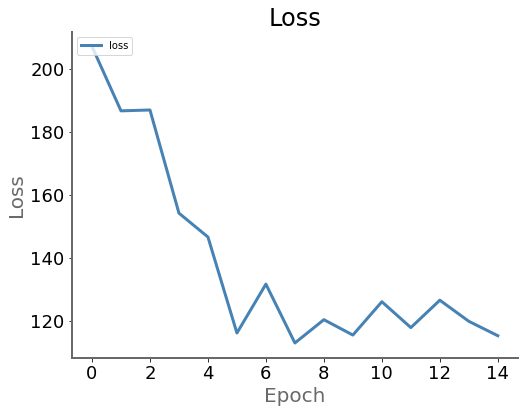

In [9]:
pwk.plot_history(history,  plot={"Loss":['loss']}, save_as='history')

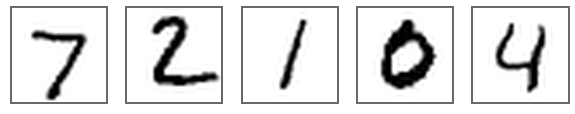

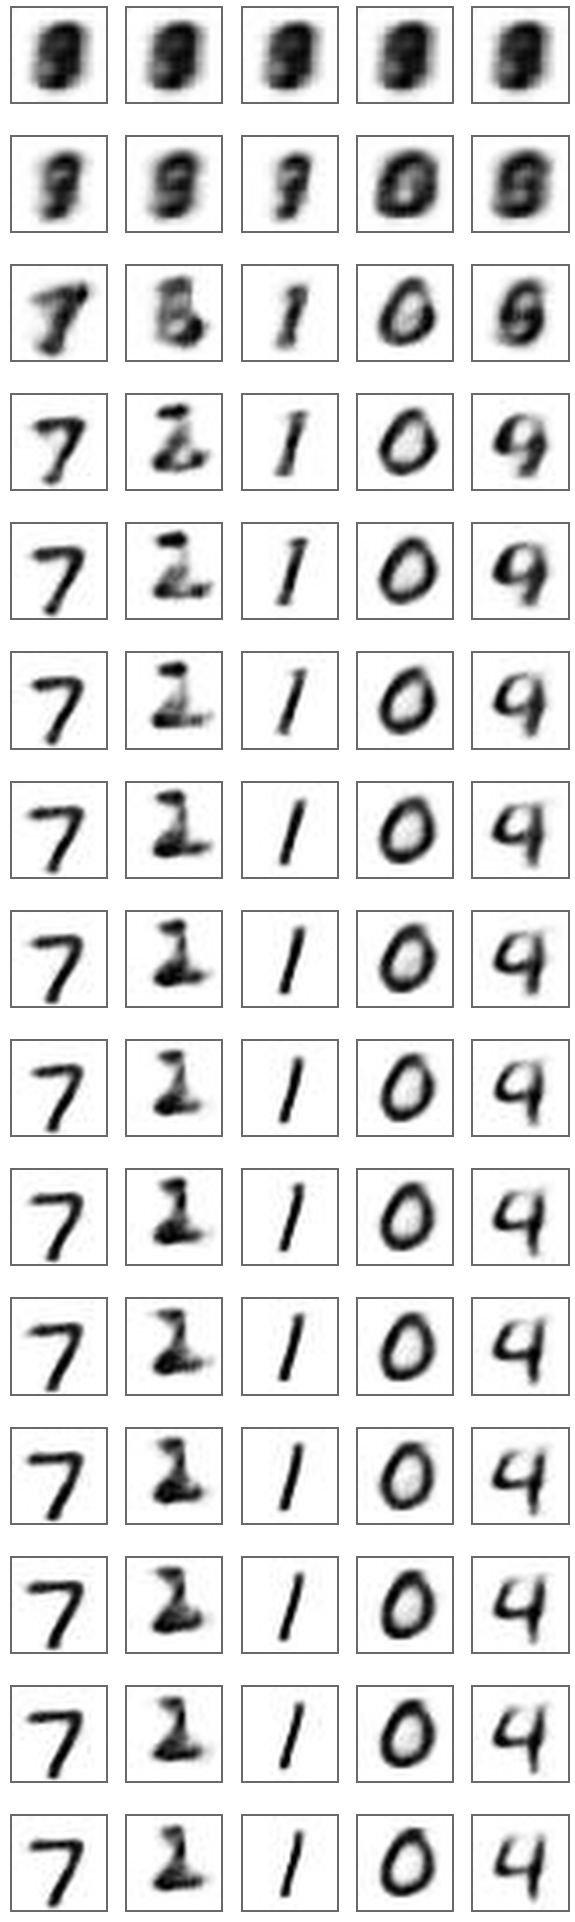

In [10]:
import matplotlib.pyplot as plt
from skimage import io

imgs=[]
labels=[]
for epoch in range(15):
    for i in range(5):
        filename = run_dir + "/images/image-{epoch:03d}-{i:02d}.jpg".format(epoch=epoch, i=i)
        img      = io.imread(filename)
        imgs.append(img)
        
pwk.plot_images(x_test[:5], None, indices='all', columns=5, x_size=2,y_size=2, save_as='01-original')
pwk.plot_images(imgs, None, indices='all', columns=5, x_size=2,y_size=2, save_as='01-reconstruct')


In [11]:
pwk.end()

End time is : Friday 25 December 2020, 19:50:24
Duration is : 00:02:06 313ms
This notebook ends here


---
<img width="80px" src="../fidle/img/00-Fidle-logo-01.svg"></img>